In [1]:
#load rpy2 magic
%load_ext rpy2.ipython

# to switch off warning messages
import warnings
warnings.filterwarnings("ignore")

# make default cell width 85% of available screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

# load R libraries & functions
%R options(warn=-1)
%R library(RColorBrewer)
%R library(ComplexHeatmap)
%R library(circlize)
%R library(dendextend)
%R library(Rtsne)
%R library(ggplot2)
%R library(gplots)
%R library(gridExtra)
%R library(DESeq2)
%R library(dendextend)
%R library(ggrepel)
    
# load python modules
import glob
import re
import sys
import os
import rpy2.robjects as robjects
import CGAT.Database as DB
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

db = "./csvdb"

In [217]:
%%R

# R functions
theme_notebook <- function(base_size=18, base_family="helvetica") {
                  (theme_set(theme_minimal(base_size=18))
                  + theme(plot.title = element_text(face="bold", size=20, hjust=0.5),
                             text = element_text(),
                             axis.title = element_text(face="bold",size = rel(1)),
                             axis.title.y = element_text(angle=90,vjust=2, size=20),
                             axis.title.x = element_text(vjust=-0.2, size=20),
                             axis.text = element_text(size=20),
                             axis.line = element_line(colour="black"),
                             axis.ticks = element_line(),
                             legend.key = element_rect(colour = NA),
                             legend.key.size= unit(0.5, "cm"),
                             legend.margin = unit(0.5, "cm"),
                             legend.text = element_text(size=14),
                             legend.title = element_text(size=16),
                             ))
}

ggplot_prcomp <- function(prcomp_object,
                          plots=list("A"=c("PC1","PC2"), "B"=c("PC3","PC4"), "C"=c("PC5","PC6")),
                          sample_information="none",
                          color="c()",
                          shape="c()",
                          label="none",
                          size=3,
                          nudge_scale_factor=40){
    require(gridExtra)
    pca = prcomp_object

    # sample_information should have the same rownames as pca$x
    pvs <- summary(pca)$importance["Proportion of Variance",]

    names = paste(names(pvs)," (",round(pvs,2),")",sep="")

    #scree plot
    fs <- data.frame(x=c(1:length(names(pvs))), y=as.vector(pvs))

    pcdf <- as.data.frame(pca$x)

    pcdf <- merge(pcdf, sample_information, by=0, all=T)

    gps = list()

    scree <- ggplot(fs, aes(x,y)) + 
                geom_point(size=4) + 
                xlab("principal component") + 
                ylab("proportion of variance") + 
                ggtitle("scree plot")

    c_lab <- function(props, C){
        return(paste(C, " (", props[[C]]*100,"%)",sep=""))
    }

    for(plot in names(plots)){

        comps <- plots[[plot]]

        PCX <- comps[1]
        PCY <- comps[2]

        nudge_x <- diff(range(pcdf[[PCX]]))/nudge_scale_factor
        nudge_y <- diff(range(pcdf[[PCY]]))/nudge_scale_factor

        gp <- ggplot(pcdf, aes_string(PCX, PCY, color=color, shape=shape))

        if(label!="none"){
            gp <- gp + geom_text(aes_string(label=label), nudge_x=nudge_x, nudge_y=nudge_y, color="black")
        }

        gp <- gp + geom_point(size=size)
        gp <- gp + xlab(c_lab(pvs,PCX)) + ylab(c_lab(pvs,PCY))

        gps[[plot]] <- gp

    }

    gps[["scree"]] <- scree

    return(gps)
}

plot_heatmap <- function(matrix, clust_method="ward.D2", dist_method="manhattan", low_opt=0.1, 
             med_opt=0.5, high_opt=0.9, labels="random", no_labels=50){

    # get vector of labels
    if (labels == "random"){
        subset <- matrix[sample(no_labels, replace=FALSE), ]
        subset <- as.integer(rownames(subset))
        labels <- matrix$gene_name[subset]
    } else{
        # modify this to optionally label top DE genes
        # or most accessible peaks
        print("Specify what to label, options=random")
    }

    rnames <- matrix$gene_name
    cnames <- sample_info$category
    matrix$gene_name <- NULL

    matrix <- data.matrix(matrix)
    rownames(matrix) <- rnames
    colnames(matrix) <- cnames

    # Calculate distance
    if(dist_method == "minkowski"){
        p=1.44 # If method is "minkowski" set p as 1.44
        dist_genes <- dist(matrix, method=dist_method, p)
        }
    else{
        dist_genes <- dist(matrix, method=dist_method)
        }

    # Clustering
    clust_genes <- hclust(dist_genes, method=clust_method)
    den_genes <- as.dendrogram(clust_genes)

    if(dist_method == "minkowski"){
         p=1.44
         dist_samples <- dist(t(matrix), method=dist_method, p)
        }
    else{
         dist_samples <- dist(t(matrix), method=dist_method)
        }

    clust_samples <- hclust(dist_samples, method=clust_method)
    den_samples <- as.dendrogram(clust_samples)

    # colour breaks
    low <- quantile(matrix, low_opt)
    med <- quantile(matrix, med_opt)
    high <- quantile(matrix, high_opt)

    ht = Heatmap(matrix, 
            col = colorRamp2(c(low, med, high), c("royalblue3", "white", "red3"), space="LAB"),
            name="Accessibility",
            cluster_rows = den_genes,
            cluster_columns = den_samples,
            column_dend_height = unit(2, "cm"),
            row_dend_width = unit(3, "cm"),
            show_row_names = FALSE, 
            column_names_gp=gpar(fontsize=18),
            heatmap_legend_param=list(legend_direction="horizontal", 
                                      color_bar = "continuous",
                                      legend_width = unit(5, "cm"), 
                                      title_position = "lefttop"),
            show_column_dend = TRUE) + 
            rowAnnotation(link=row_anno_link(at=subset, labels=labels), width=unit(1, "cm") + 
                          max_text_width(labels))

    draw(ht, heatmap_legend_side = "bottom")
}

# Set ggplot theme
theme_set(theme_notebook(base_size=18))
Palette <- c("#E69F00", "#0072B2", "#D55E00", "#009E73", "#56B4E9",  "#999999", "#F0E442")

# ATAC-seq - Differential Accessibility
* Analysis based upon a merged peakset of all detected ATAC peaks (either from all-fragments or size-filtered)
* Reads are counted over merged set of intervals using bedtools multicov 
* raw counts are analysed for differential accessibility with DESeq2
* Significant differentially accessible peaks used for data exploration 
* and saved to file:

In [3]:
# get peak/readcounts to use from pipeline.ini
with open("pipeline.ini", "r") as o:
    for line in o:
        match = re.findall("^peaks=.*", line)
        if len(match) > 0:  
            filt = ''.join([x.split("=")[-1] for x in match])

# import counts & upper quantile normalise
def get_counts(filt=filt, db=db):
    # get counts, filter on fragment size

    if filt == "size_filt":
        peaks = "<150bp"
    if filt == "all":
        peaks = "all_fragments"
        
    statement = '''select sample_id, peak_id, total from all_norm_counts
                where size_filt == "%(peaks)s" ''' % locals()
        
    df = DB.fetch_DataFrame(statement, db)

    df = df.pivot("sample_id", "peak_id", "total").transpose()
    df.index.name = None

    return df

counts = get_counts()
# counts.head()

# DESeq2
### Sample information table:
* "condition" column used for DESeq2 design

In [4]:
sample_info = DB.fetch_DataFrame('''select * from sample_info''', db)
sample_info.index = sample_info["sample_id"]
sample_info.index.name = None
sample_info.head(len(sample_info))

,category,condition,replicate,sample_id
WTCHG_461111_05,BM_1,BM,1,WTCHG_461111_05
WTCHG_461111_06,BL_1,BL,1,WTCHG_461111_06
WTCHG_461111_07,MEM_1,MEM,1,WTCHG_461111_07
WTCHG_461111_08,AP_1,AP,1,WTCHG_461111_08
WTCHG_461111_09,BM_2,BM,2,WTCHG_461111_09
WTCHG_461111_10,BL_2,BL,2,WTCHG_461111_10
WTCHG_461111_11,MEM_2,MEM,2,WTCHG_461111_11
WTCHG_461111_12,AP_2,AP,2,WTCHG_461111_12


### Variance stabilizing transformation (VST) 
* Count data are normalised by division by the size factors
* Size factors are based on the fitted dispersion-mean relations
* The transformation also normalises with respect to library size

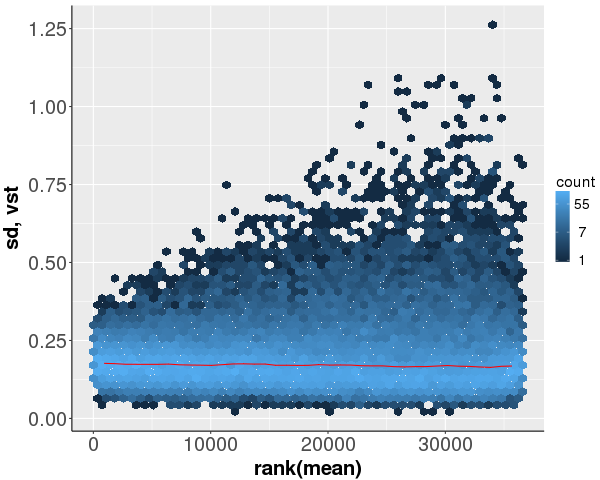

In [5]:
 %%R -i counts,sample_info -w 600

require(vsn)

# replicates as characters
sample_info$replicate <- as.character(sample_info$replicate)

# build a DESeqDataSet from the count matrix
# sample_info must have same rownames as colnames in count matrix
dds <- DESeqDataSetFromMatrix(countData=counts, 
                              colData= sample_info, 
                              design = ~ condition )

dds <- estimateSizeFactors(dds)

# apply VST
vstMat <- assay(varianceStabilizingTransformation(dds, blind=TRUE, fitType="local"))
colnames(vstMat) <- rownames(sample_info)
notAllZero <- (rowMeans(vstMat)> min(vstMat))

meanSdPlot(vstMat[notAllZero,], ylab="sd, vst",plot=T)

# run DESeq2
dds <- DESeq(dds,  fitType="local")
# res <- results(dds, cooksCutoff=FALSE)
res <- results(dds)

### Check dispersion estimate fit 
* default fit type = "local"

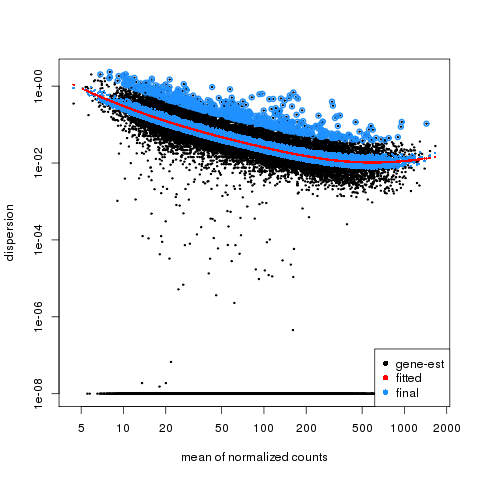

In [6]:
%%R
plotDispEsts(dds) # check dispersion estimate fit

### DESeq2 Differential Accessibility Results

In [7]:
%R summary(res)


out of 36594 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)     : 1812, 5% 
LFC < 0 (down)   : 1308, 3.6% 
outliers [1]     : 0, 0% 
low counts [2]   : 7095, 19% 
(mean count < 22)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



## DESeq2 QC Metrics

### Cook's Distance
* Diagnostic test for outliers, calculated for each gene and sample 
* Cooks distance is a measure of how much a single sample is influencing fitted coefficients for a gene, large values indicate an outlier count

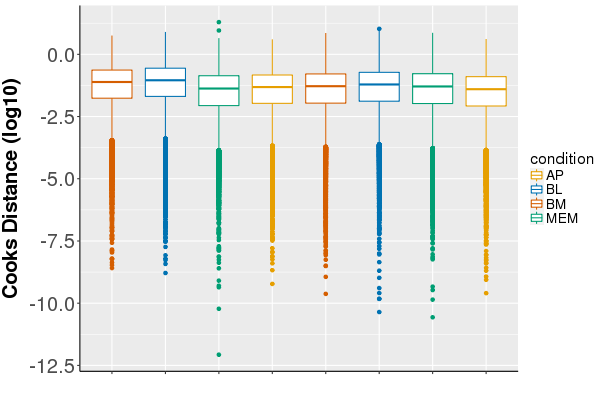

In [8]:
%%R -w 600 -h 400

plot_cooks <- function(dds, sample_info){
    
    require(reshape)
    require(reshape2)
    
    # DESeq function calculates Cooks distance (diagnostic test for outliers) for every gene and sample. 
    
    # Cooks distance is a measure of how much a single sample is influencing fitted coefficients for a gene, 
    # large values indicate an outlier count

    cooks <- melt(as.data.frame(log10(assays(dds)[["cooks"]])))
    cooks <- merge(cooks, sample_info, by.x="variable", by.y=0, all=T)
    
    p <- ggplot(cooks, aes(y=value, x=variable, colour=condition)) +  
        geom_boxplot()  + 
        theme(axis.text.x=element_blank()) + 
        labs(y="Cooks Distance (log10)", x="") +
        scale_colour_manual(values=Palette)
    
    return(p)
}

a <- plot_cooks(dds, sample_info)
a

### Count Normalisation

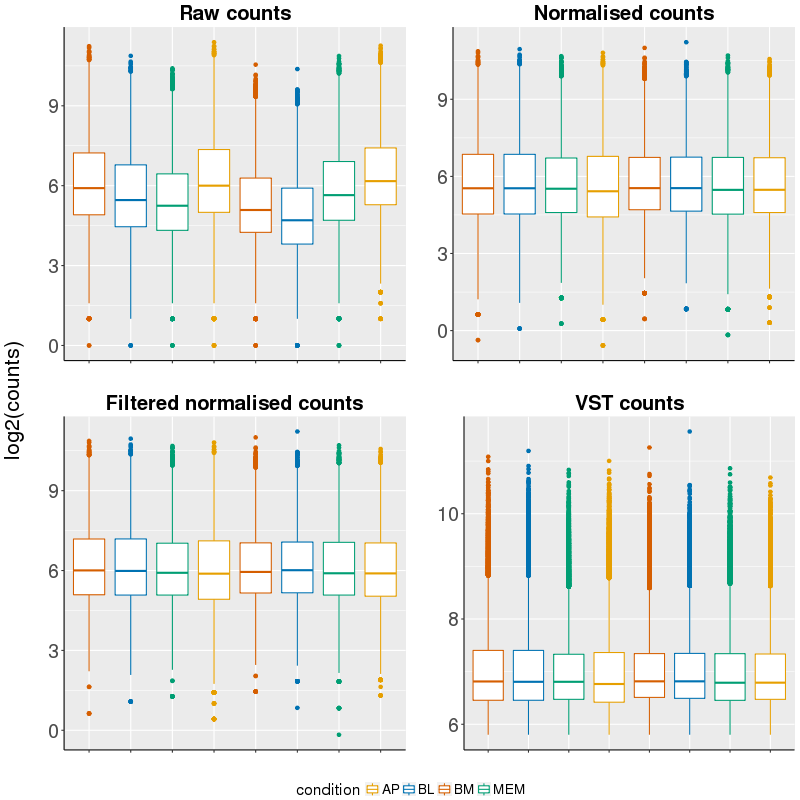

In [9]:
%%R -w 800 -h 800 -o filt_norm_counts

plot_countNorm <- function(dds, sample_info){
    
    # raw counts
    raw <- melt(t(counts(dds)))
    raw <- merge(raw, sample_info, by.x="X1", by.y=0, all=T)

    p1 <- ggplot(raw, aes(y=log2(value), x=X1, colour=condition)) + 
            geom_boxplot() + 
            theme(axis.text.x=element_blank()) +
            labs(title="Raw counts", x="", y="") + 
            scale_colour_manual(values=Palette)

    # norm counts = counts(dds) / sizeFactors(dds)
    norm <- melt(t(counts(dds, normalized=T)))
    norm <- merge(norm, sample_info, by.x="X1", by.y=0, all=T)

    p2 <- ggplot(norm, aes(y=log2(value), x=X1, colour=condition)) + 
            geom_boxplot() + 
            theme(axis.text.x=element_blank()) +
            labs(title="Normalised counts", y="", x="") + 
            scale_colour_manual(values=Palette)

    # VST counts
    colnames(vstMat) <- dds@colData@rownames
    data <-melt(vstMat[notAllZero,])
    data <- merge(data, sample_info, by.x="X2", by.y=0, all=T)

    p3 <- ggplot(data, aes(y=value, x=X2, colour=condition)) + 
            geom_boxplot()  + 
            theme(axis.text.x=element_blank()) +
            labs(title="VST counts", y="", x="") + 
            scale_colour_manual(values=Palette) 

    # normalised counts with excluded counts (padj == NA) removed
    # counts excluded by: Cooks cutoff & independent filtering
    filtered_genes <- subset(res, res@listData$padj != "NA")@"rownames" # get sig DE gene names
    filt_norm_counts <- subset(melt(t(counts(dds,normalized=T))), X2 %in% filtered_genes)

    filt_norm_counts_info <- merge(filt_norm_counts, sample_info, by.x="X1", by.y=0, all=T)

    p4 <- ggplot(filt_norm_counts_info, aes(y=log2(value), x=X1, colour=condition)) + 
            geom_boxplot() + 
            theme(axis.text.x=element_blank()) +
            labs(title="Filtered normalised counts", x="", y="") + 
            scale_colour_manual(values=Palette) +
            theme(legend.direction="horizontal")
    
    get_legend <- function(a.gplot){ 
      tmp <- ggplot_gtable(ggplot_build(a.gplot)) 
      leg <- which(sapply(tmp$grobs, function(x) x$name) == "guide-box") 
      legend <- tmp$grobs[[leg]] 
      return(legend)}
                      
    key <- get_legend(p4)

    plots = list(p1, p2, p3, p4, key, filt_norm_counts)

    return(plots)
}

plots <- plot_countNorm(dds, sample_info)

a <- plots[[1]]
b <- plots[[2]]
c <- plots[[3]]
d <- plots[[4]]
e <- plots[[5]]

filt_norm_counts <- plots[[6]]

grid.arrange(a + theme(legend.position="none"), 
             b + theme(legend.position="none"), 
             d + theme(legend.position="none"), 
             c + theme(legend.position="none"), 
             bottom=e, ncol=2, nrow=2,
             left=textGrob("log2(counts)", gp=gpar(fontsize=21, fontfamily="Helvetica"), rot=90))

In [10]:
# rearrange data -> by gene
filt_norm_counts = filt_norm_counts.pivot("X2", "X1", "value")
filt_norm_counts.index.name = None

### Relative Log Expression (RLE)
* Normalises samples for size factors
* Briefly, the gene expression in each sample is normalised to the median expression of that gene across all samples & counts are log2 transformed
* RLE should be centered over 0, dispersion from this indicates poor quality normalisation

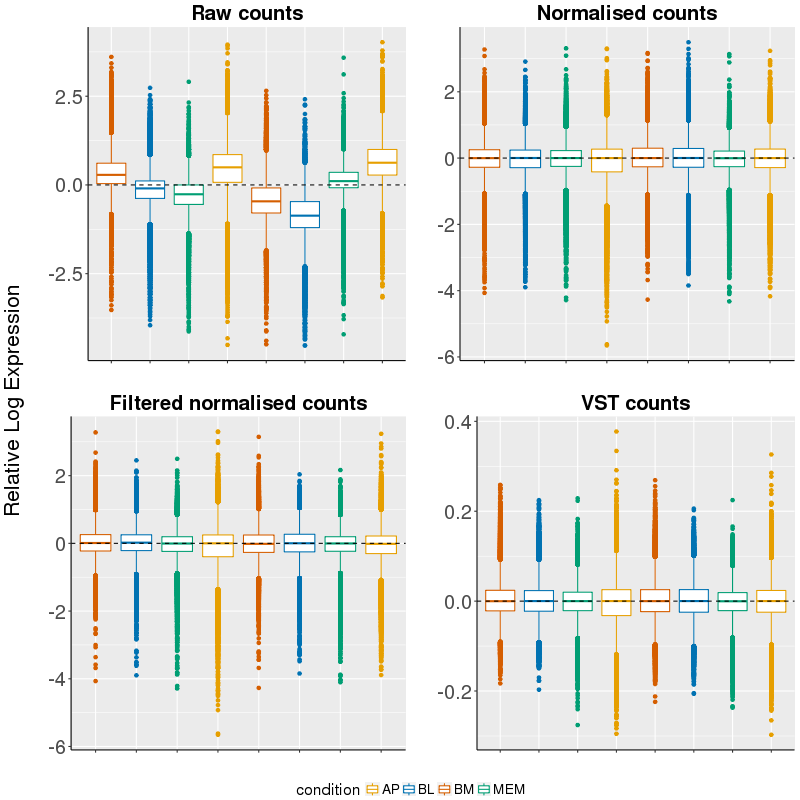

In [11]:
%%R -w 800 -h 800 -i filt_norm_counts

plot_countRLE <- function(dds, sample_info, filt_norm_counts){

    # raw counts
    rawc <- apply(counts(dds),1,median)
    rle_raw <- log2(counts(dds)/rawc)
    rlem_raw <- melt(t(rle_raw))
    rlem_raw <- merge(rlem_raw, sample_info, by.x="X1", by.y=0, all=T)

    p1 <- ggplot(rlem_raw, aes(y=value, x=X1, colour=condition)) + geom_boxplot() + 
                    theme(axis.text.x=element_blank()) + 
                    geom_hline(yintercept=0, lty="dashed", colour="black") +
                    labs(title="Raw counts", y="", x="") +
                    scale_colour_manual(values=c(Palette)) +
                    theme(legend.direction="horizontal")

    # norm counts
    normc <- apply(counts(dds, normalized=TRUE),1,median)
    rle_norm <- log2(counts(dds, normalized=TRUE)/normc)
    rlem_norm <- melt(t(rle_norm))
    rlem_norm <- merge(rlem_norm, sample_info, by.x="X1", by.y=0, all=T)
    head(rlem_norm)

    p2 <- ggplot(rlem_norm, aes(y=value, x=X1, colour=condition)) + geom_boxplot() + 
                    theme(axis.text.x=element_blank()) + 
                    geom_hline(yintercept=0, lty="dashed", colour="black") +
                    labs(title="Normalised counts", y="", x="") +
                    scale_colour_manual(values=c(Palette))

    # Norm counts with filtering (Cooks distance, independent filtering)
    filtc <- apply(filt_norm_counts,1,median)
    rle_filt <- log2(filt_norm_counts/filtc)
    rlem_filt <- melt(t(rle_filt))
    rlem_filt <- merge(rlem_filt, sample_info, by.x="X1", by.y=0, all=T)
    # head(rlem_filt)

    p3 <- ggplot(rlem_filt, aes(y=value, x=X1, colour=condition)) + geom_boxplot() + 
                    theme(axis.text.x=element_blank()) + 
                    geom_hline(yintercept=0, lty="dashed", colour="black") +
                    labs(title="Filtered normalised counts", y="", x="") +
                    scale_colour_manual(values=c(Palette))

    # VST counts
    vstc <- apply(vstMat,1,median)
    rle_vst <- log2(vstMat/vstc)
    rlem_vst <- melt(t(rle_vst))
    rlem_vst <- merge(rlem_vst, sample_info, by.x="X1", by.y=0, all=T)

    p4 <- ggplot(rlem_vst, aes(y=value, x=X1, colour=condition)) + geom_boxplot() + 
                    theme(axis.text.x=element_blank()) + 
                    geom_hline(yintercept=0, lty="dashed", colour="black") +
                    labs(title="VST counts", y="", x="") +
                    scale_colour_manual(values=c(Palette)) +
                    theme(legend.direction="horizontal")

    get_legend <- function(a.gplot){ 
    tmp <- ggplot_gtable(ggplot_build(a.gplot)) 
    leg <- which(sapply(tmp$grobs, function(x) x$name) == "guide-box") 
    legend <- tmp$grobs[[leg]] 
    return(legend)}

    key <- get_legend(p4)
    
    plots = list(p1, p2, p3, p4, key)
    
    return(plots)
}

plots <- plot_countRLE(dds, sample_info, filt_norm_counts)

a <- plots[[1]]   
b <- plots[[2]] 
c <- plots[[3]]   
d <- plots[[4]] 
e <- plots[[5]] 

grid.arrange(a + theme(legend.position="none"), 
             b + theme(legend.position="none"), 
             c + theme(legend.position="none"), 
             d + theme(legend.position="none"), 
             ncol=2, nrow=2, bottom=e,
             left=textGrob("Relative Log Expression", gp=gpar(fontsize=21, fontfamily="Helvetica"), rot=90))

## Exploratory Analysis 
### Dimensionality Reduction

In [12]:
%%R -o sigVst

# get significant VST counts
sigvar_peaks <- rownames(res)[res$padj<0.05 & !is.na(res$padj)] # get sig DE genes
sigVst <- vstMat[sigvar_peaks,]

sigVst <- as.data.frame(sigVst)
# sigVst
# head(sigVst)

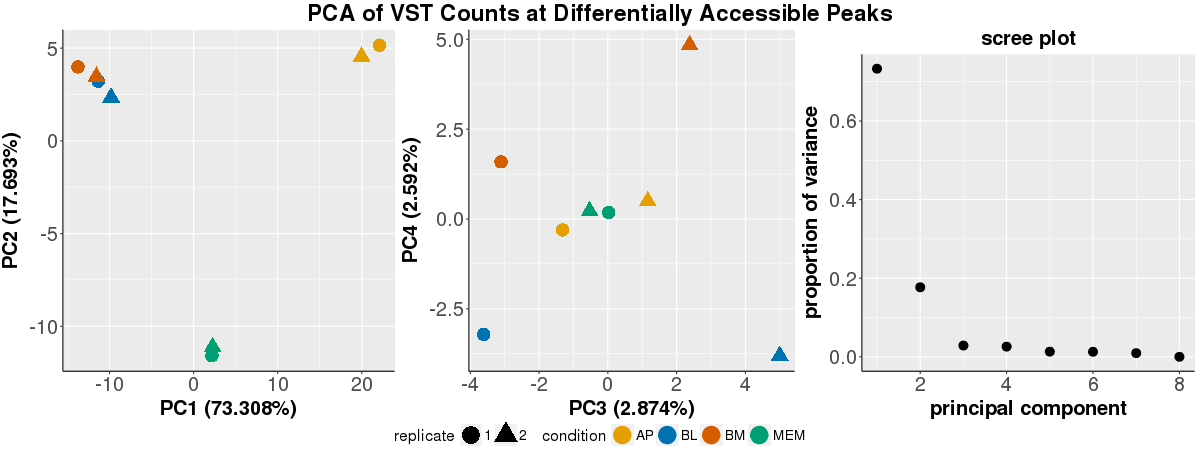

In [116]:
%%R -w 1200 -h 450
                      
pca <- prcomp(t(sigVst), scale=FALSE)

pca_plots <- ggplot_prcomp(pca, 
             plots=list("A"=c("PC1","PC2"), "B"=c("PC3", "PC4")),
             sample_information=sample_info, 
             shape="replicate", 
             color="condition",
#              label="replicate",
             size=6,
             nudge_scale_factor=30) 

a <- pca_plots$A
b <- pca_plots$B
c <- pca_plots$scree

a = a + scale_colour_manual(values=Palette) +
        guides(colour=guide_legend(override.aes=list(size=8)), shape=guide_legend(override.aes=list(size=8)))
               
b = b + scale_colour_manual(values=Palette) 

c = c 

get_legend <- function(a.gplot){ 
tmp <- ggplot_gtable(ggplot_build(a.gplot)) 
leg <- which(sapply(tmp$grobs, function(x) x$name) == "guide-box") 
legend <- tmp$grobs[[leg]] 
return(legend)}

a <- a + theme(legend.direction="horizontal", legend.box="horizontal")
legend <- get_legend(a)
                      
grid.arrange(top=textGrob("PCA of VST Counts at Differentially Accessible Peaks", 
                          gp=gpar(fontface="bold", fontfamily="Helvetica", fontsize=23)),
             a + theme(legend.position="none"), b + theme(legend.position="none"), c, 
             bottom=legend, ncol=3, nrow=1)

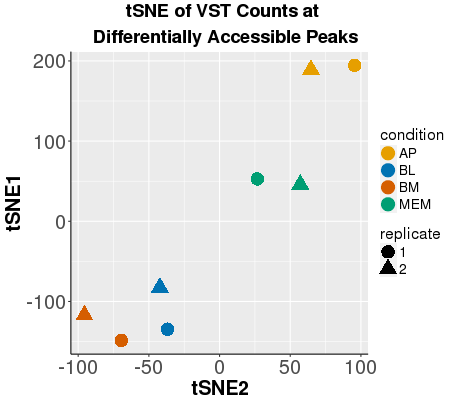

In [119]:
%%R -w 450 -h 400

library(Rtsne)
tsne_out = Rtsne(t(sigVst), pca=T, perplexity=2)

tsne_df <- as.data.frame(tsne_out$Y)
rownames(tsne_df) <- colnames(t(sample_info))
colnames(tsne_df) <- c("tSNE1", "tSNE2")

tsne_df <- merge(tsne_df, sample_info, by=0)

tsne_plot <- ggplot(tsne_df, aes(y=tSNE1, x=tSNE2, colour=condition, shape=factor(replicate))) + 
                    geom_point(size=6) + 
                    scale_colour_manual(values=Palette) +
                    scale_shape_manual(values=c(16,17,22,23,25),name="replicate")

grid.arrange(top=textGrob("tSNE of VST Counts at \nDifferentially Accessible Peaks", 
             gp=gpar(fontface="bold", fontfamily="Helvetica", fontsize=18)), 
             tsne_plot, ncol=1, nrow=1)

## Heatmap of all Differentially Accessible Peaks 
* VST counts

In [15]:
# get peak to gene annotations
peak2gene = DB.fetch_DataFrame('''select distinct a.gene_name, a.gene_id, b.peak_id from 
                               ensemblGeneset a, merged_peaks_GREAT_annotated b 
                               where a.gene_id = b.gene_id''', db)

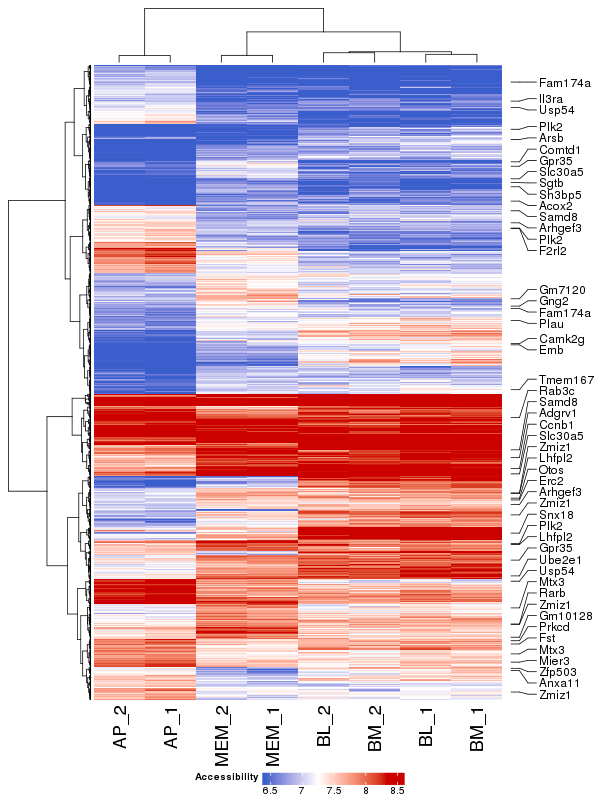

In [218]:
%%R -i sigVst,peak2gene -w 600 -h 800

mat <- merge(sigVst, peak2gene[c("peak_id", "gene_name")], by.x=0, by.y="peak_id")
mat <- mat[, !names(mat) %in% c("Row.names")]

plot_heatmap(mat, clust_method="ward.D2", dist_method="manhattan", low_opt=0.1, 
             med_opt=0.5, high_opt=0.9, labels="random", no_labels=50)

## DE Peaks - Contrasts
* Pairwise comparisons of differentially accessible peaks
* Adjusted p-value < 0.05 & fold change > 2

In [17]:
%%R -o condition_pairs

# get pairs of sample comparisons
a <- unique(sample_info$condition)
b <- combn(a, 2, simplify=FALSE)
condition_pairs <- as.data.frame(b)

In [18]:
# reformat df
condition_pairs = condition_pairs.transpose()
condition_pairs.reset_index(drop=True, inplace=True)
condition_pairs.columns = ["a", "b"]
condition_pairs["comparison"] = condition_pairs["a"] + "_VS_" + condition_pairs["b"]

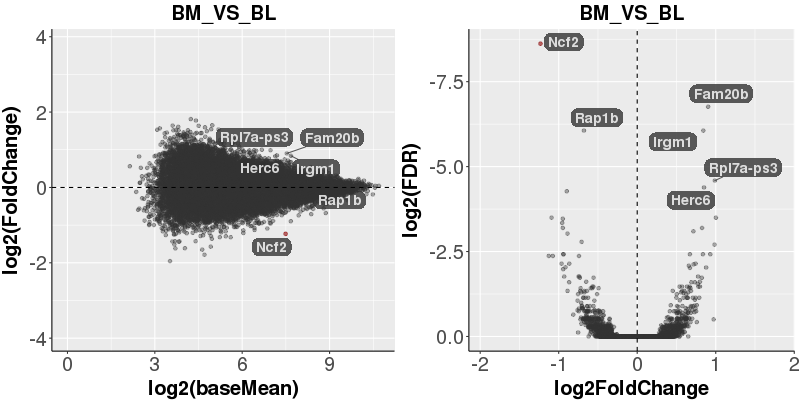

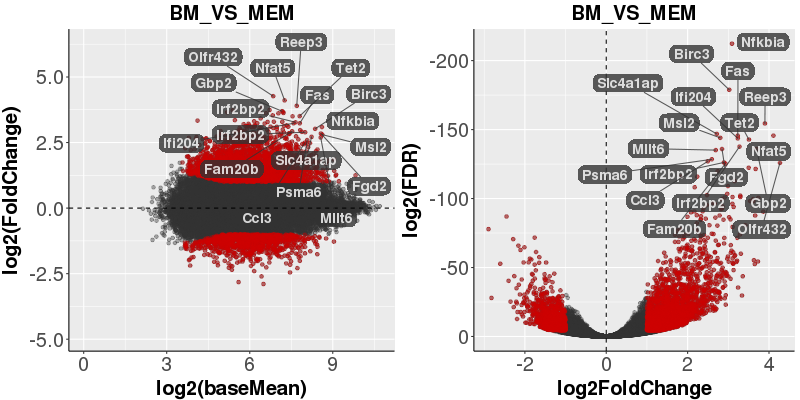

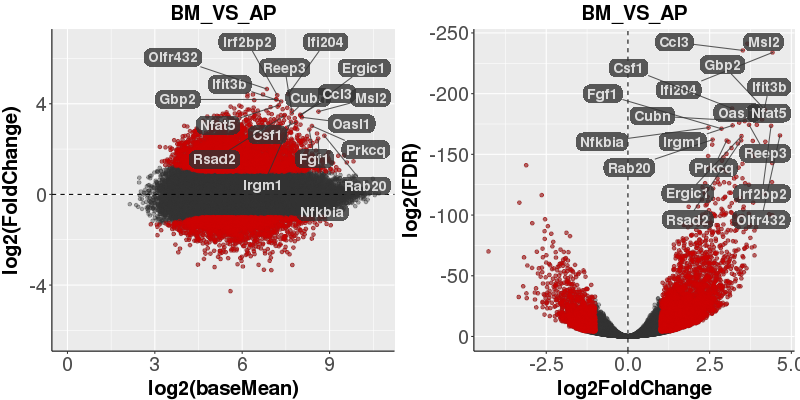

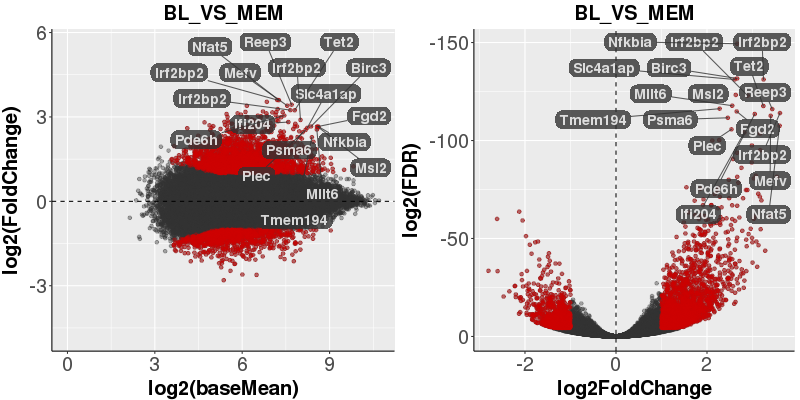

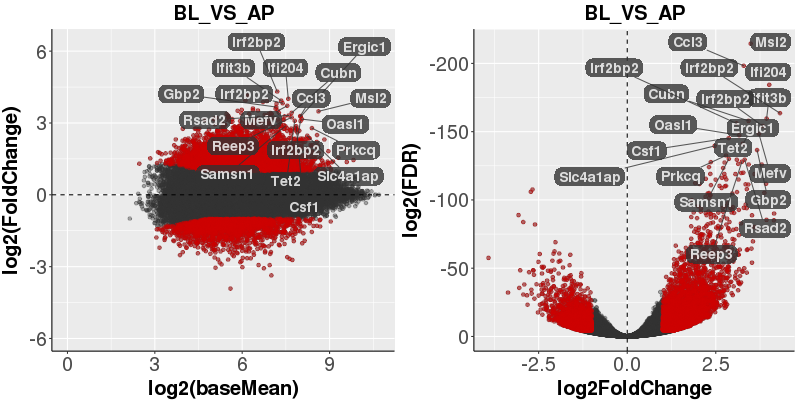

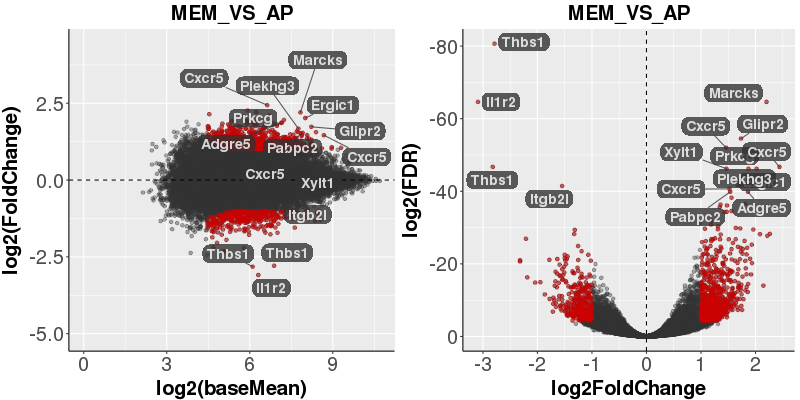

In [19]:
%%R -h 400 -w 800 -i condition_pairs

MA <- function(df, title="", gene_info=gene_info){
      
    df <- merge(df, gene_info[c("gene_id", "gene_name", "peak_id")], by.x=0, by.y="peak_id")
    
    MA <- ggplot(subset(df, padj > 0.05 | is.na(padj)), aes(y=log2FoldChange, x=log2(baseMean))) + 
            geom_point(alpha=0.4, colour="gray20") +
            geom_point(data=subset(df, padj < 0.05 & log2FoldChange < 1 | padj < 0.05 & log2FoldChange > -1), 
                       aes(y=log2FoldChange, x=log2(baseMean)), alpha=0.4, colour="gray20") +
            geom_point(data=subset(df, padj < 0.05 & log2FoldChange > 1 | padj < 0.05 & log2FoldChange < -1), 
                       aes(y=log2FoldChange, x=log2(baseMean)), alpha=0.4, colour="red3") +
            scale_y_continuous(limits=c(min(df$log2FoldChange)-2, max(df$log2FoldChange)+2)) +
            scale_x_continuous(limits=c(0, max(log2(df$baseMean)))) +
            labs(y="log2(FoldChange)", title=title) +
            geom_hline(yintercept=0, lty="dashed", col="black") +
            geom_label_repel(data=df[df$padj < quantile(df$padj, 0.0005, na.rm=TRUE), ], 
                             aes(y=log2FoldChange, x=log2(baseMean), 
                             label=gene_name), size=5, 
                             label.padding=unit(0.3, "lines"), label.r=unit(0.5, "lines"), segment.color = "gray20", 
                             fill="gray20", colour="white", fontface="bold", label.size=NA, alpha=0.8)

    return(MA)
}

volcano <- function(df, title="", gene_info=gene_info){
      
    df <- merge(df, gene_info[c("gene_id", "gene_name", "peak_id")], by.x=0, by.y="peak_id")
    
    volcano <- ggplot(subset(df, padj > 0.05 | is.na(padj)), aes(y=log2(padj), x=log2FoldChange)) + 
            geom_point(alpha=0.4, colour="gray20") +
            geom_point(data=subset(df, padj < 0.05 & log2FoldChange < 1 | padj < 0.05 & log2FoldChange > -1), 
                       aes(y=log2(padj), x=log2FoldChange), alpha=0.4, colour="gray20") +
            geom_point(data=subset(df, padj < 0.05 & log2FoldChange > 1 | padj < 0.05 & log2FoldChange < -1), 
                       aes(y=log2(padj), x=log2FoldChange), alpha=0.4, colour="red3") +
            labs(y="log2(FDR)", title=title) +
            scale_y_reverse(limits=c(0, min(log2(df$padj)))) +
            scale_x_continuous(limits=c(min(df$log2FoldChange), max(df$log2FoldChange))) +
            geom_vline(xintercept=0, lty="dashed", col="black") +
            geom_label_repel(data=df[df$padj < quantile(df$padj, 0.0005, na.rm=TRUE), ], 
                             aes(y=log2(padj), x=log2FoldChange, 
                             label=gene_name), size=5, 
                             label.padding=unit(0.3, "lines"), label.r=unit(0.5, "lines"), segment.color = "gray20", 
                             fill="gray20", colour="white", fontface="bold", label.size=NA, alpha=0.8)

    return(volcano)
}

n = 0
for (line in 1:nrow(condition_pairs)){
    n = n + 1

    sample = condition_pairs[n, ]

    a <- as.character(sample$a)
    b <- as.character(sample$b)
    title <- as.character(sample$comparison)

    plot <- as.data.frame(results(dds, contrast=c("condition", a, b)))
    p1 <- (MA(plot, title, gene_info=peak2gene))
    p2 <- (volcano(plot, title, gene_info=peak2gene))

    grid.arrange(p1, p2, ncol=2, nrow=1)
}

## Summary Table 
* Peaks with adjusted p-value < 0.05 and fold change > 2

In [128]:
%%R -o sig_peaks

# get no. sig diff. accessible peaks

n = 0
contrasts = list()
for (line in 1:nrow(condition_pairs)){
    n = n + 1

    sample = condition_pairs[n, ]

    a <- as.character(sample$a)
    b <- as.character(sample$b)
    title <- as.character(sample$comparison)
    
    if (length(title)[1] > 0){
        contrasts[[title]] <- c(a, b)
    }

    df <- results(dds, contrast=c("condition", a, b))
    res <- subset(df, padj < 0.05 & log2FoldChange > 1 |  padj < 0.05 & log2FoldChange < -1)
    upreg <- subset(res, log2FoldChange > 0)
    downreg <- subset(res, log2FoldChange < 0)
    
    if (n == 1) {
        sig_peaks <- as.data.frame(c(length(res$padj), length(upreg$padj), length(downreg$padj), title), byrow=F)
        sig_peaks <- t(sig_peaks)
    } else{
        df <- as.data.frame(c(length(res$padj), length(upreg$padj), length(downreg$padj), title), byrow=F)
        df <- t(df)
        sig_peaks <- rbind(sig_peaks, df)
    }

}

sig_peaks <- as.data.frame(sig_peaks)
rownames(sig_peaks) <- NULL
colnames(sig_peaks) <- c("No. Peaks", "Upreg", "Downreg", "Contrast")

In [129]:
sig_peaks["No. Peaks"] = sig_peaks["No. Peaks"].apply(lambda x: int(x))
sig_peaks.sort_values("No. Peaks", ascending=False).head(len(sig_peaks))

,No. Peaks,Upreg,Downreg,Contrast
3,6120,4164,1956,BM_VS_AP
5,5581,3680,1901,BL_VS_AP
2,3763,2680,1083,BM_VS_MEM
4,2998,2072,926,BL_VS_MEM
6,988,661,327,MEM_VS_AP
1,1,0,1,BM_VS_BL
